## Workshop 2.2: Model Inversion and Differential Privacy

### Learning Objectives:

By the end of this notebook, you will:
- Understand how AI models are vulnerable to data leakage
- Perform a model inversion attack
- Learn how to prevent attacks through training with differential privacy

### Step 1: Load the dataset

   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


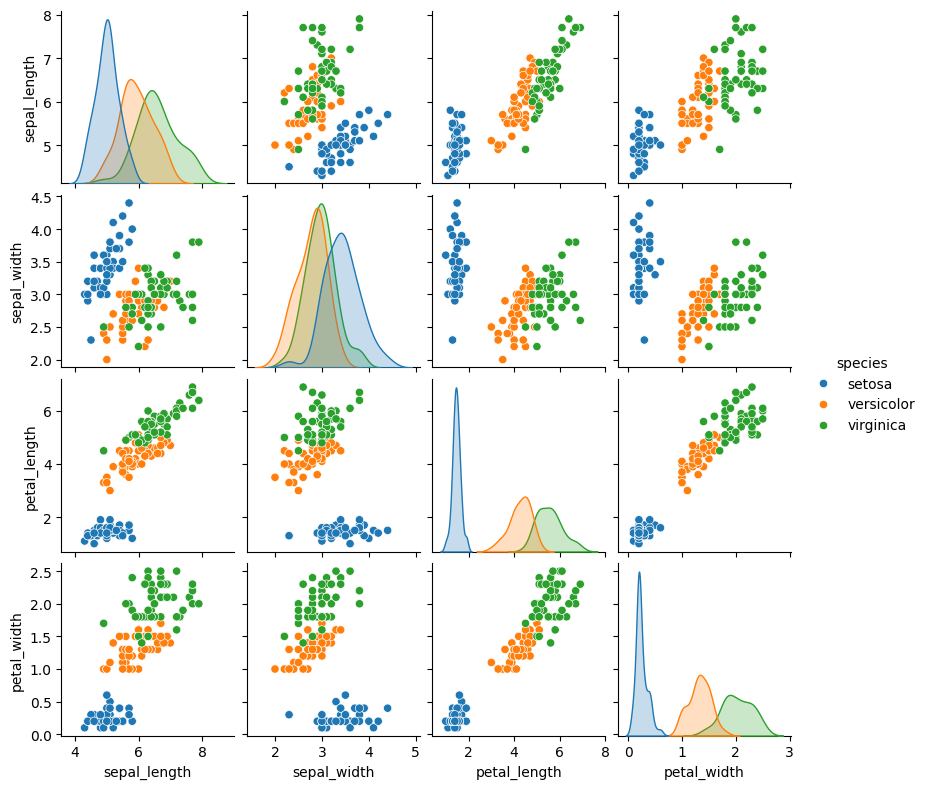

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.load_dataset("iris")
# We want to load the dataset as a pandas DataFrame to keep the feature names for later
iris = sns.load_dataset("iris")
print(iris.head())

sns.pairplot(iris, 
            hue='species', height=2)
plt.show()

Notice that the there is a distinct split between setosa and the other two classes in the petal length feature. We will be focusing on this feature in our attack.

### Step 2: Train a simple model

Model Accuracy: 0.97


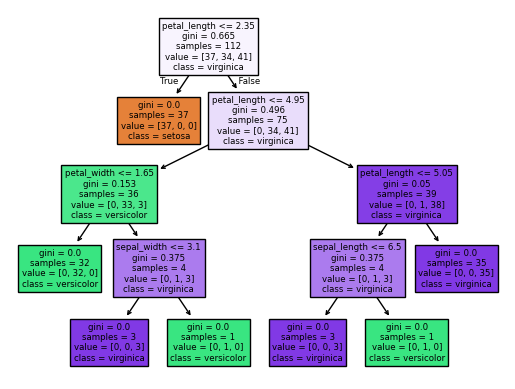

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

# Prepare the Data
# Split the data into training and testing sets (75% train, 25% test)
train, test = train_test_split(iris, test_size=0.25, random_state=0)

# Train a Model
# We will use a Decision Tree classifier for this example
model = DecisionTreeClassifier(random_state=42)
model.fit(train.drop(columns=['species']), train['species'])

plot_tree(model, feature_names=iris.drop(columns=['species']).columns, class_names=iris['species'].unique(), filled=True)

# Make Predictions
y_pred = model.predict(test.drop(columns=['species']))

# Evaluate Performance
accuracy = accuracy_score(test['species'], y_pred)
print(f"Model Accuracy: {accuracy:.2f}")


### Step 3: Model Inversion

Sampled petal length: 6.32, Predicted probabilities: [0. 0. 1.]
Sampled petal length: 4.16, Predicted probabilities: [0. 1. 0.]
Sampled petal length: 1.85, Predicted probabilities: [1. 0. 0.]
Sampled petal length: 4.90, Predicted probabilities: [0. 1. 0.]
Sampled petal length: 4.03, Predicted probabilities: [0. 1. 0.]
Sampled petal length: 4.82, Predicted probabilities: [0. 1. 0.]
Sampled petal length: 2.31, Predicted probabilities: [1. 0. 0.]
Sampled petal length: 1.59, Predicted probabilities: [1. 0. 0.]
Sampled petal length: 2.18, Predicted probabilities: [1. 0. 0.]
Sampled petal length: 4.23, Predicted probabilities: [0. 1. 0.]


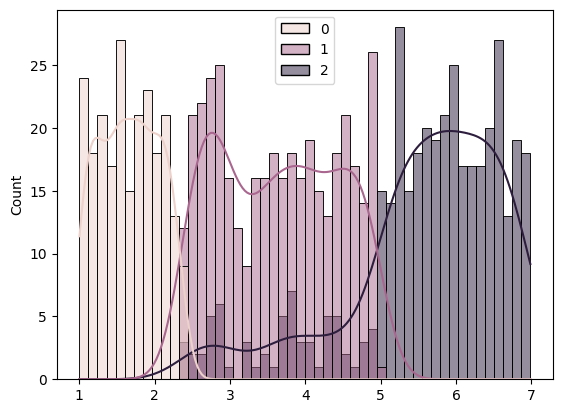

In [127]:
import pandas as pd
import numpy as np

def inversion_attack(model, target_feature, feature_ranges, n_samples=1000):
    inferred_values = []
    # For each sample, generate random feature values within the specified ranges
    for _ in range(n_samples):
        synthetic_data = {}
        for feature, frange in feature_ranges.items():
            synthetic_data[feature] = np.random.uniform(frange[0], frange[1])
        synthetic_data = pd.DataFrame([synthetic_data])
        
        # Get the model predictions for this synthetic datapoint
        probas = model.predict_proba(synthetic_data)[0]
        inferred_values.append((synthetic_data[target_feature][0], probas))
    
    return inferred_values

# Attack the model to infer the 'petal length' feature
feature_ranges = {'sepal_length': (4.0, 7.9), 'sepal_width': (2.0, 4.5), 'petal_length': (1.0, 7.0), 'petal_width': (0.1, 2.5)}
results = inversion_attack(model, 'petal_length', feature_ranges)

# Output the results
for i in range(10):
    print(f"Sampled petal length: {results[i][0]:.2f}, Predicted probabilities: {results[i][1]}")

# Plot the petal length
sns.histplot(x=[r[0] for r in results], bins=50, kde=True, hue=[np.argmax(r[1]) for r in results])
plt.show()

Compare this histogram to the petal_length histogram when analyzing the data. By sampling enough data points we have identified the same distinction between setosa (class 0) and the other two classes. We also know that the petal length of the setosa class is in the range of 1 and around 2.2.

### Step 4: Differential Privacy

In [123]:
import numpy as np

# Softmax function for normalizing probabilities
def softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1)

# Function to add noise for differential privacy
def private_predict(model, X, epsilon=0.1):
    probas = model.predict_proba(X)[:]
    noise = np.random.laplace(0, 1/epsilon, probas.shape)

    # Add the noise directly to the probabilities
    noisy_probas = probas + noise

    # Normalize to get valid probabilities again 
    # noise can make probabilities negative and not sum to 1
    return softmax(noisy_probas)

# Example usage of private_predict
test_example = pd.DataFrame([test.drop(columns=['species']).iloc[0]])
example = private_predict(model, test_example, epsilon=0.1)[0]
print(test_example)
print(example)

     sepal_length  sepal_width  petal_length  petal_width
114           5.8          2.8           5.1          2.4
[9.76955313e-01 2.30446779e-02 9.19750247e-09]


### Step 5: Run the attack again


Sample of Attack Results:
Sampled petal length: 4.63, Predicted probabilities: [3.41099015e-04 9.99326394e-01 3.32507178e-04]
Sampled petal length: 6.35, Predicted probabilities: [0.00319579 0.41941279 0.57739141]
Sampled petal length: 4.16, Predicted probabilities: [0.01499662 0.95245306 0.03255032]
Sampled petal length: 2.85, Predicted probabilities: [0.0161408  0.13249729 0.85136191]
Sampled petal length: 5.35, Predicted probabilities: [0.64030705 0.35796368 0.00172926]
Sampled petal length: 3.18, Predicted probabilities: [2.60233999e-04 7.78316932e-02 9.21908073e-01]
Sampled petal length: 6.95, Predicted probabilities: [0.17352361 0.04272741 0.78374898]
Sampled petal length: 3.23, Predicted probabilities: [0.06030944 0.86469271 0.07499785]
Sampled petal length: 2.21, Predicted probabilities: [0.67251114 0.18550608 0.14198278]
Sampled petal length: 4.70, Predicted probabilities: [8.57340034e-05 9.99911063e-01 3.20286656e-06]


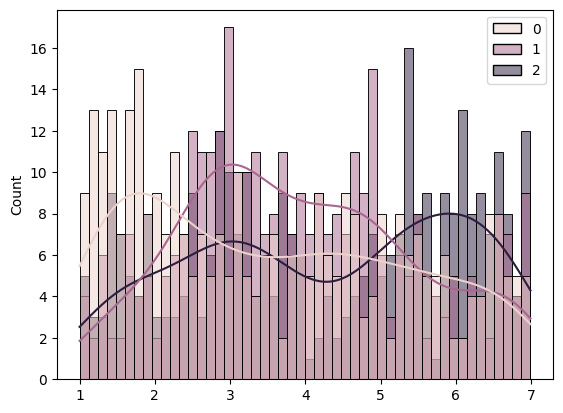

In [130]:
# Attack Simulation
def inversion_attack(model, target_feature, feature_ranges, n_samples=1000, epsilon=0.1):
    inferred_values = []
    for _ in range(n_samples):
        # Generate synthetic feature data
        synthetic_data = {}
        for feature, frange in feature_ranges.items():
            synthetic_data[feature] = np.random.uniform(frange[0], frange[1])
        synthetic_data = pd.DataFrame([synthetic_data])
        predicted = private_predict(model, synthetic_data, epsilon=epsilon)[0]
        inferred_values.append((synthetic_data[target_feature][0], predicted))

    return inferred_values

# Running the attack
feature_ranges = {'sepal_length': (4.0, 7.9), 'sepal_width': (2.0, 4.5), 'petal_length': (1.0, 7.0), 'petal_width': (0.1, 2.5)}
attack_results = inversion_attack(model, 'petal_length', feature_ranges, epsilon=0.5)

# Print a sample of the attack results
print("\nSample of Attack Results:")
for i in range(10):
    print(f"Sampled petal length: {attack_results[i][0]:.2f}, Predicted probabilities: {attack_results[i][1]}")

# Plot the petal length
sns.histplot(x=[r[0] for r in attack_results], bins=50, kde=True, hue=[np.argmax(r[1]) for r in attack_results])
plt.show()

Notice that differential privacy made it impossible to clearly distinguish between the three classes. Our membership inference attack was unable to find any meaningful data.